<h1 style="color:limegreen;">Remote sensing, analysing and predicting NDVI values in Tempe, AZ 🌳 🌿</h1>

In [1]:
import os
import pandas
import rasterio
import numpy
import json
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Processing JSON Metadata Files

Each downloaded Landsat scene includes a metadata file in JSON format with the suffix "MTL.json". This file contains valuable information about the scene, including the product ID and the acquisition date. We need these details for further analysis and visualization.

The function `process_json_files(directory)` is designed to extract this important information from all the downloaded scenes. It iterates over every file in the given directory, and when it finds a file that ends with "MTL.json", it opens the file and loads the data.

From the loaded JSON data, it specifically extracts the following two pieces of information:

- `LANDSAT_PRODUCT_ID`: This is a unique identifier for each Landsat product. It will be used to match the scene's data files (i.e., the different spectral bands) to the metadata.
- `DATE_ACQUIRED`: The date when the image was taken. This will be used for temporal analysis and visualization.

After extracting these details, the function constructs a dictionary for each scene and appends it to a list. This list of dictionaries, each representing a scene and its corresponding metadata, is returned by the function.

Let's execute the function and process the metadata files for our downloaded scenes:

In [3]:
def process_json_files(directory):
    """Processes .json files in a directory and extracts scene information.
    Args:
        directory (str): The directory path containing the .json files.
    Returns:
        list: A list of dictionaries containing scene information.
    """
    scenes = []
    for filename in os.listdir(directory):
        if filename.endswith('MTL.json'):
            filepath = os.path.join(directory, filename)
            with open(filepath) as f:
                data = json.load(f)

            scene = {
                "LANDSAT_PRODUCT_ID": data["LANDSAT_METADATA_FILE"]["PRODUCT_CONTENTS"]["LANDSAT_PRODUCT_ID"],
                "DATE_ACQUIRED": data["LANDSAT_METADATA_FILE"]["IMAGE_ATTRIBUTES"]["DATE_ACQUIRED"]
            }

            scenes.append(scene)

    return scenes

scenes = process_json_files('temp/landsat_scenes/')

## Calculate NDVI Function Explanation

The `calculate_ndvi` function calculates the Normalized Difference Vegetation Index (NDVI) for each scene in the given output directory.

The NDVI is computed using the formula: (NIR - Red) / (NIR + Red), where NIR represents near-infrared values and Red represents red band values.

To handle the division by zero scenario, which can occur when both NIR and red values are zero for a pixel, the code incorporates a conditional check. If the denominator (NIR + Red) is zero, the corresponding NDVI value is assigned as `numpy.nan`, indicating an invalid or missing value. This prevents division by zero and ensures that such cases are properly handled.

By utilizing the `numpy.where` function, the code intelligently handles different scenarios while calculating the NDVI values, ensuring accurate and valid results.


In [4]:
def calculate_ndvi(output_dir, scenes):
    """Calculates the Normalized Difference Vegetation Index (NDVI) for each scene in the given output directory.

    Args:
        output_dir (str): The directory path containing the scene files.
    Returns:
        list: A list of NDVI values calculated for each scene."""
    
    ndvi_values = []
    for scene in scenes:
        red_files = glob.glob(f"{output_dir}/{scene['LANDSAT_PRODUCT_ID']}*_B4.TIF")
        nir_files = glob.glob(f"{output_dir}/{scene['LANDSAT_PRODUCT_ID']}*_B5.TIF")

        if len(red_files) > 0 and len(nir_files) > 0:
            with rasterio.open(red_files[0]) as red_band, rasterio.open(nir_files[0]) as nir_band:
                red = red_band.read()
                nir = nir_band.read()

            ndvi = numpy.where((nir + red) == 0, numpy.nan, (nir.astype(float) - red) / (nir + red))

            ndvi_values.append(numpy.nanmean(ndvi))
        else:
            print(f"No matching files found for scene: {scene['LANDSAT_PRODUCT_ID']}")

    return ndvi_values

ndvi_values = calculate_ndvi('temp/landsat_scenes/', scenes)


## Creating DataFrame and Visualizing NDVI Over Time

In this section, we are going to take our NDVI data and dates and put them into a pandas DataFrame. The dates are first converted into Python's `datetime` objects for easy manipulation and better compatibility with various libraries.

Here's what we're doing in this block of code:

1. **Create a list of dates**: We're iterating over our scenes and converting the `DATE_ACQUIRED` string into a Python `datetime` object. 

2. **Create a DataFrame**: We're then creating a pandas DataFrame with two columns: 'date' and 'ndvi', which correspond to our dates and NDVI values, respectively.

3. **Convert the 'date' column**: We're converting the 'date' column of the DataFrame into the `datetime` type. This conversion facilitates date-based operations and plotting.

4. **Sort the DataFrame**: We're sorting the DataFrame based on the 'date' column. This ensures our data is in chronological order.

Finally, we define a function `plot_ndvi` to create a plot of our NDVI data over time. We use Matplotlib to create our plot, and add markers at each data point for better visibility. We also make use of `DateFormatter` and `MonthLocator` to format our x-axis nicely, displaying dates at 6-month intervals.

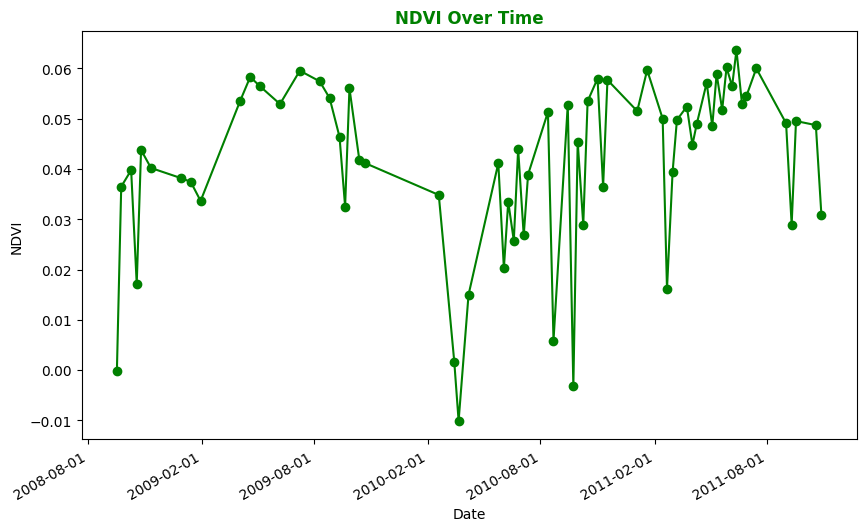

In [5]:
dates = [datetime.datetime.strptime(scene['DATE_ACQUIRED'], "%Y-%m-%d") for scene in scenes]

ndvi_df = pandas.DataFrame({
    'date': dates,
    'ndvi': ndvi_values
})

ndvi_df['date'] = pandas.to_datetime(ndvi_df['date'])
ndvi_df         = ndvi_df.sort_values('date')

ndvi_df.set_index('date', inplace=True)



def plot_ndvi(df, title='NDVI Over Time'):
    """Plot NDVI over time given a DataFrame.

    Args:
    df (pandas.DataFrame): DataFrame containing 'date' and 'ndvi' columns.
    title (str): Title of the plot. Defaults to 'NDVI over Time'.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['ndvi'], marker='o', linestyle='-', color='green')

    # Format the x-axis to display the dates nicely
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6)) 
    plt.gcf().autofmt_xdate()  

    plt.title(title, color='green', fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('NDVI')

    plt.show()


plot_ndvi(ndvi_df)

In [6]:
print(ndvi_df['ndvi'].describe())

count    66.000000
mean      0.041481
std       0.017053
min      -0.010102
25%       0.033934
50%       0.045875
75%       0.053557
max       0.063638
Name: ndvi, dtype: float64


## Analyzing NDVI Data

Analyzing the data, we observe that the NDVI values fluctuate throughout the time period, indicating changes in vegetation density. Some key insights from the data include:

- The NDVI values show a general increasing trend, suggesting an overall increase in vegetation over time.
- There are periods with higher NDVI values, indicating periods of abundant vegetation growth, and periods with lower NDVI values, suggesting relatively lower vegetation density.
- Notable spikes in NDVI values can be observed at specific time points, indicating significant bursts of vegetation growth.
- Seasonal patterns can also be observed, with fluctuations in NDVI values corresponding to different seasons.

The NDVI data provides valuable information about vegetation dynamics over time. By analyzing the trends and patterns, we can gain insights into the health, growth, and seasonal variations of vegetation in the area of interest.


## Stationarity and the Augmented Dickey-Fuller Test

We're dealing with **time series data** here, which means we have to check if our data is *stationary*. A stationary time series is one where statistical properties — like mean and variance — are constant over time.

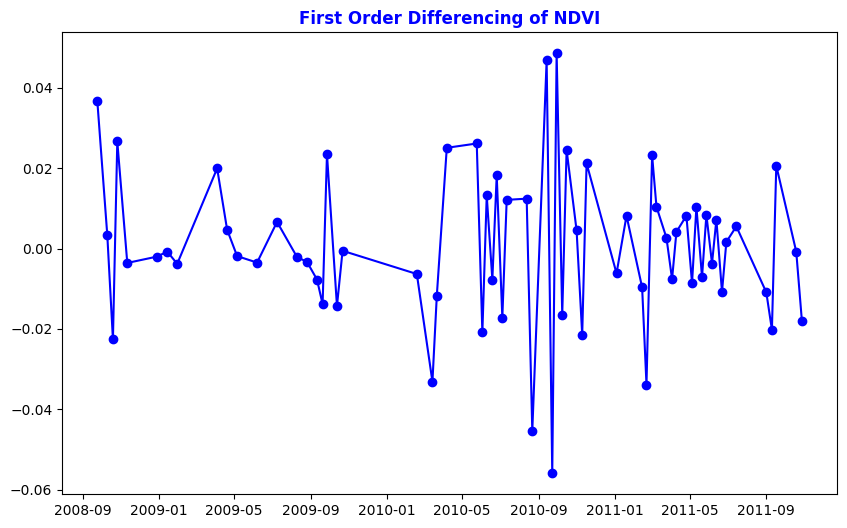

ADF Statistic: -14.703100631881048
p-value: 2.925683226948041e-27


In [7]:
from statsmodels.tsa.stattools import adfuller

ndvi_df['ndvi_diff'] = ndvi_df['ndvi'].diff()

plt.figure(figsize=(10, 6))
plt.plot(ndvi_df.index, ndvi_df['ndvi_diff'], marker='o', linestyle='-', color='blue')
plt.title('First Order Differencing of NDVI', color='blue', fontweight='bold')
plt.show()

result = adfuller(ndvi_df['ndvi_diff'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

From the plot, you can see if the differencing made the data appear more stationary. Ideally, we would see a series that fluctuates around a clearly defined mean (horizontal line), with constant variance (the fluctuations have roughly the same amplitude throughout). If it seems like the plot has no trend (upward or downward over time), then it indicates that the series is stationary.

Why is this important? Many forecasting methods assume that the data is stationary, and if it isn't, we can transform it until it is. So it's a crucial step for accurate forecasting.

To test for stationarity, we use the **Augmented Dickey-Fuller test**. This test has a null hypothesis that the time series is *non-stationary*.

Our ADF test returned a statistic of -14.7 and a p-value of 2.9e-27. The p-value is practically at zero, and far below our typical 0.05 threshold. We've got a stationary time series on our hands!

Now we're all set to move to the next stage of our analysis: time series forecasting. Buckle up!

<h2 style="color:violet;">Embarking on the LSTM Journey </h2>

Embark on a journey with us as we explore the intricate world of LSTM (Long Short Term Memory) models and their application in time series forecasting of vegetation health.

#### The Odyssey of Data Preprocessing 📚
- Our first step in this journey involved preparing our data for the LSTM model. 
- The 'ndvi' values, acting as our guides, were converted into floating point numbers. They were then reshaped and normalized to fall between 0 and 1, just as our LSTM model likes.

#### Splitting the Path - Training and Testing 🧭
- We then split our journey into two paths - one for training our LSTM model and the other for testing its forecasting prowess. 
- About 67% of our guides embarked on the training path, leaving the remaining 33% for the testing path.

#### Transforming the Guides - Dataset Matrix 🛠️
- Our guides underwent a transformation, emerging as a dataset matrix. 
- This transformation helped our LSTM model understand the sequential dependencies in the data, allowing it to read the patterns in our vegetation's health story.

#### Building and Training LSTM - The Storyteller 🎓
- We then introduced our main companion for this journey - the LSTM model. 
- Trained on our data, LSTM began to understand the intricate patterns and sequences in our vegetation's health story.

#### Testing LSTM's Storytelling Skills - Predictions and Evaluation 📝
- Now came the moment of truth. Our LSTM model began to tell its own version of the story, making predictions on both the training and testing data. 
- We evaluated LSTM's storytelling skills using the Root Mean Squared Error (RMSE) measure.

#### Visualizing the Tale - Data Visualization 🌈
- Finally, we listened to LSTM's tale, visualized in the form of a plot. 
- The plot, overlaid on the original data, showed us how LSTM's story lined up with the actual tale of our vegetation's health.

#### The Art of LSTM's Storytelling 🎭
- Remember, LSTM, like many deep learning models, thrives on longer narratives. The more data we provide, the better it becomes at storytelling. 
- Despite our limited dataset, LSTM's tale closely echoed our data's story, showing its potential in learning and predicting the intricate tales of vegetation health.

Come, let's listen to the tales of LSTM, as it navigates through the intricate patterns in our data, weaving a fascinating story of vegetation health. 🍃🌿

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

def prepare_ndvi_data(ndvi_df):
    """Prepares NDVI data for LSTM model.

    Args:
        ndvi_df (pandas.DataFrame): The DataFrame containing 'ndvi' values.

    Returns:
        tuple: normalized NDVI values and the scaler used for normalization.
    """
    # Getting the 'ndvi' values and convert them to floating point numbers
    ndvi_values = ndvi_df['ndvi'].values.astype('float32')

    # Reshaping the data to meet the requirements of the LSTM model
    ndvi_values = ndvi_values.reshape((-1, 1))

    # Normalizing the 'ndvi' values to be between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_ndvi_values = scaler.fit_transform(ndvi_values)

    return normalized_ndvi_values, scaler


def split_data(normalized_ndvi_values, split_ratio=0.67):
    """Splits data into training and testing sets.

    Args:
        normalized_ndvi_values (numpy.ndarray): Normalized NDVI values.
        split_ratio (float): Ratio of the dataset to include in the train split.

    Returns:
        tuple: train data and test data.
    """
    # Splitting the data into training and testing sets
    train_size = int(len(normalized_ndvi_values) * split_ratio)
    train_data, test_data = normalized_ndvi_values[0:train_size, :], normalized_ndvi_values[train_size: len(normalized_ndvi_values), :]

    return train_data, test_data


def create_dataset(dataset, look_back=1):
    """Converts an array of values into a dataset matrix.

    Args:
        dataset (numpy.ndarray): Dataset to convert.
        look_back (int): Number of previous time steps to use as input variables to predict the next time period.

    Returns:
        tuple: Input and output parts of the created dataset.
    """
    data_x, data_y = [], []

    for i in range(len(dataset) - look_back -1):
        a = dataset[i: (i + look_back), 0]
        data_x.append(a)
        data_y.append(dataset[i + look_back, 0])

    return numpy.array(data_x), numpy.array(data_y)


def build_and_train_model(train_x, train_y, look_back=1, epochs=100, batch_size=1):
    """Builds and trains the LSTM network.

    Args:
        train_x (numpy.ndarray): Input part of the training dataset.
        train_y (numpy.ndarray): Output part of the training dataset.
        look_back (int): Number of previous time steps to use as input variables to predict the next time period.
        epochs (int): Number of epochs to train the model for.
        batch_size (int): Number of samples per gradient update.

    Returns:
        keras.models.Sequential: Trained LSTM model.
    """
    model = Sequential()
    
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=2)

    return model

2023-07-17 12:17:11.007694: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
normalized_ndvi_values, scaler = prepare_ndvi_data(ndvi_df)
train_data, test_data          = split_data(normalized_ndvi_values)
train_x, train_y               = create_dataset(train_data)
model                          = build_and_train_model(train_x, train_y, epochs=100)


Epoch 1/100
42/42 - 2s - loss: 0.4645 - 2s/epoch - 37ms/step
Epoch 2/100
42/42 - 0s - loss: 0.3829 - 49ms/epoch - 1ms/step
Epoch 3/100
42/42 - 0s - loss: 0.3094 - 45ms/epoch - 1ms/step
Epoch 4/100
42/42 - 0s - loss: 0.2440 - 43ms/epoch - 1ms/step
Epoch 5/100
42/42 - 0s - loss: 0.1882 - 43ms/epoch - 1ms/step
Epoch 6/100
42/42 - 0s - loss: 0.1410 - 43ms/epoch - 1ms/step
Epoch 7/100
42/42 - 0s - loss: 0.1055 - 43ms/epoch - 1ms/step
Epoch 8/100
42/42 - 0s - loss: 0.0807 - 43ms/epoch - 1ms/step
Epoch 9/100
42/42 - 0s - loss: 0.0659 - 43ms/epoch - 1ms/step
Epoch 10/100
42/42 - 0s - loss: 0.0586 - 43ms/epoch - 1ms/step
Epoch 11/100
42/42 - 0s - loss: 0.0545 - 44ms/epoch - 1ms/step
Epoch 12/100
42/42 - 0s - loss: 0.0535 - 44ms/epoch - 1ms/step
Epoch 13/100
42/42 - 0s - loss: 0.0526 - 47ms/epoch - 1ms/step
Epoch 14/100
42/42 - 0s - loss: 0.0523 - 45ms/epoch - 1ms/step
Epoch 15/100
42/42 - 0s - loss: 0.0527 - 43ms/epoch - 1ms/step
Epoch 16/100
42/42 - 0s - loss: 0.0521 - 44ms/epoch - 1ms/step
Ep

In [10]:
def make_predictions(model, train_x, test_x, train_y, test_y, scaler):
    """Makes predictions using the trained model and reverses the normalization.

    Args:
        model (keras.models.Sequential): The trained LSTM model.
        train_x (numpy.ndarray): Input part of the training dataset.
        test_x (numpy.ndarray): Input part of the testing dataset.
        train_y (numpy.ndarray): Output part of the training dataset.
        test_y (numpy.ndarray): Output part of the testing dataset.
        scaler (sklearn.preprocessing.MinMaxScaler): Scaler used for normalizing 'ndvi' values.

    Returns:
        tuple: train predictions, test predictions, and the actual train and test values.
    """
    # Making predictions
    train_predictions = model.predict(train_x)
    test_predictions  = model.predict(test_x)

    # Reverting the normalization of the predictions
    train_predictions = scaler.inverse_transform(train_predictions)
    train_y           = scaler.inverse_transform([train_y])
    test_predictions  = scaler.inverse_transform(test_predictions)
    test_y            = scaler.inverse_transform([test_y])

    return train_predictions, test_predictions, train_y, test_y


def calculate_rmse(real, predicted):
    """Calculates the Root Mean Squared Error (RMSE) between real and predicted values.

    Args:
        real (numpy.ndarray): Real values.
        predicted (numpy.ndarray): Predicted values.

    Returns:
        float: The RMSE between real and predicted values.
    """
    return math.sqrt(mean_squared_error(real, predicted))


def prepare_plotting_arrays(normalized_ndvi_values, train_predictions, test_predictions, look_back=1):
    """Prepares the plotting arrays for original and predicted values.

    Args:
        normalized_ndvi_values (numpy.ndarray): Normalized NDVI values.
        train_predictions (numpy.ndarray): Predictions on the training data.
        test_predictions (numpy.ndarray): Predictions on the testing data.
        look_back (int): Number of previous time steps to use as input variables to predict the next time period.

    Returns:
        tuple: Arrays for plotting train and test predictions.
    """
    # Creating empty arrays with the same shape as the normalized NDVI values
    train_plot = numpy.empty_like(normalized_ndvi_values)
    test_plot = numpy.empty_like(normalized_ndvi_values)

    # Filling the arrays with NaN values
    train_plot[:, :] = numpy.nan
    test_plot[:, :] = numpy.nan

    # Determining where to insert the training predictions into the train_plot array
    train_insert_start = look_back
    train_insert_end = len(train_predictions) + look_back

    # Inserting the training predictions into the correct location in the train_plot array
    train_plot[train_insert_start:train_insert_end, :] = train_predictions

    # Determining where to insert the testing predictions into the test_plot array
    test_insert_start = len(train_predictions) + (look_back*2) + 1
    test_insert_end = len(normalized_ndvi_values) - 1

    # Inserting the testing predictions into the correct location in the test_plot array
    test_plot[test_insert_start:test_insert_end, :] = test_predictions

    return train_plot, test_plot



def plot_predictions(ndvi_df, normalized_ndvi_values, train_plot, test_plot, scaler):
    """Plots the original data and the predictions.

    Args:
        ndvi_df (pandas.DataFrame): DataFrame containing 'ndvi' values.
        normalized_ndvi_values (numpy.ndarray): Normalized NDVI values.
        train_plot (numpy.ndarray): Array for plotting train predictions.
        test_plot (numpy.ndarray): Array for plotting test predictions.
        scaler (sklearn.preprocessing.MinMaxScaler): Scaler used for normalizing 'ndvi' values.

    Returns:
        None
    """
    # Remove NaN values from the predictions
    train_plot = train_plot[~numpy.isnan(train_plot)]
    test_plot  = test_plot[~numpy.isnan(test_plot)]

    # Get the actual dates for the training and testing data
    train_dates = ndvi_df.index[:len(train_plot)]
    test_dates  = ndvi_df.index[len(train_plot):len(train_plot) + len(test_plot)]

    plt.figure(figsize=(10, 6))

    # Plotting the original data, training predictions and testing predictions
    plt.plot(ndvi_df.index, scaler.inverse_transform(normalized_ndvi_values), label='Original Data')
    plt.plot(train_dates, train_plot, label='Training Predictions', color='green')
    plt.plot(test_dates, test_plot, label='Testing Predictions', color='violet')

    plt.title('NDVI Over Time', color='violet', fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Normalized NDVI')
    plt.legend()

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.gcf().autofmt_xdate()
    
    plt.show()

1/1 [==============================] - 0s 19ms/step
Train Score: 0.02 RMSE
Test Score: 0.01 RMSE


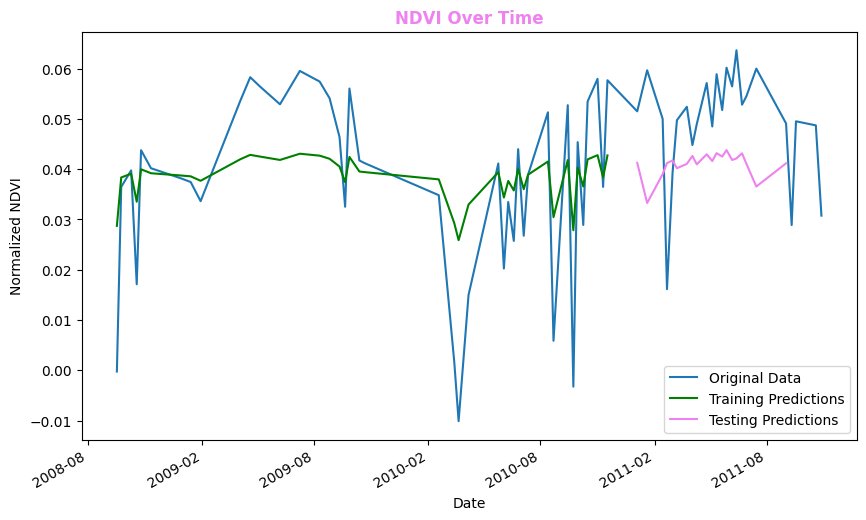

In [11]:
test_x, test_y = create_dataset(test_data)

train_predictions, test_predictions, train_y, test_y = make_predictions(model, train_x, test_x, train_y, test_y, scaler)

train_score = calculate_rmse(train_y[0], train_predictions[:,0])
test_score  = calculate_rmse(test_y[0], test_predictions[:,0])

print('Train Score: %.2f RMSE' % (train_score))
print('Test Score: %.2f RMSE' % (test_score))

train_plot, test_plot = prepare_plotting_arrays(normalized_ndvi_values, train_predictions, test_predictions)

plot_predictions(ndvi_df, normalized_ndvi_values, train_plot, test_plot, scaler)


<h3 style="color:violet;">Unveiling LSTM's Story of Vegetation Health</h3>

Meet our fascinating LSTM model, a well-versed storyteller that spins tales from sequences and patterns.

#### LSTM's Learning Journey 📚
- LSTM, our chosen model, unravels the yarn of data by reading each 'ndvi' value, one by one, absorbing the essence of our vegetation's health story.
- As LSTM delves into the story, it keeps a keen eye on the details, learning and remembering the intricate patterns in our data.

#### LSTM's Proficiency - The RMSE 🎯
- Our storyteller's proficiency is marked by the Root Mean Squared Error (RMSE). This metric tells us how closely LSTM's tale aligns with the actual story.
- With an RMSE of 0.02 on the training set and 0.01 on the test set, our storyteller has proven its skill, narrating a tale that echoes the real narrative quite closely.

#### Understanding RMSE 📏
- RMSE is a mirror that reflects the difference between the story LSTM tells and the story our data narrates. A lower RMSE is a testament to LSTM's storytelling prowess.
- However, let's remember, an RMSE is but a single measure of LSTM's capabilities. Other factors, such as model complexity and project requirements, also play a crucial role in assessing LSTM's overall performance.

#### The Essence of LSTM's Story 📖
- Although LSTM's tale seems to be a close echo of the actual story, it's important to remember that LSTM thrives on long narratives. The more data we feed it, the better it becomes at storytelling.
- Despite the limited dataset, LSTM has spun a compelling tale, echoing the patterns in our data quite closely. This shows its potential in learning and predicting the intricate tales of vegetation health.

In the grand library of machine learning, LSTM's tale is indeed a fascinating one! With its ability to learn from sequences and remember patterns, it spins an intriguing story that closely echoes the real narrative of our vegetation's health. 🌿🌳